## NEST simulation of a detailed olivocerebellar scaffold network with point neurons

Through this notebook you can run simulations of an olivocerebellar scaffold model with E-GLIF point neurons [_Geminiani A<sup>*</sup>, Pedrocchi A, D’Angelo E and Casellato C, Front. Comput. Neurosci., 2019_]


</br>

<div align=justify>The cortical cerebellar scaffold (300um x 200um) includes the main neuron types and connections in the cerebellar cortex. This cortical module is subdivided into two microzones (associated to Z+ and Z- Purkinje cell types) along the parasagittal direction and connected to Deep Cerebellar and Inferior Olive nuclei (DCN and IO, respectively). Neurons are modelled as E-GLIF point neurons [_Geminiani et al., Front Neuroinform, 2018_, _Geminiani et al., Front Comput Neurosci, 2019_], able to reproduce the main firing properties of cerebellar cells (e.g. autorhythm, adaptation, rebound bursting, oscillations) with limited computational load. 
The network is stimulated with a 4-Hz background Poisson process and a 100-Hz burst lasting 100 ms. </div>

<sup>*</sup> alice.geminiani@unipv.it



## Using this notebook
 
- The notebook includes 3 main sections:

    1. __Preparation of the environment__, where the environment for simulations is set (e.g. the neural simulator NEST)
    2. __Simulation__, where the simulation is prepared (defining the neural populations and the connections in the network, and the input stimuli) and run
    3. __Simulation data analysis__, where raster plot and PSTH of recorded neural populations can be visualized.
    



## 1. Preparation of the environment

Setting of everything that is needed to run the simulation

In [1]:

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_nest.config import *

from tvb_multiscale.tvb_nest.nest_models.builders.nest_factory import compile_modules
compile_modules("cereb", recompile=True, config=CONFIGURED)


2021-05-12 15:52:14,715 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2021-05-12 15:52:14,715 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2021-05-12 15:52:14,717 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2021-05-12 15:52:14,717 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2021-05-12 15:52:14,721 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2021-05-12 15:52:14,721 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2021-05-12 15:52:14,724 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2021-05-12 15:52:14,724 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2021-05-12 15:52:14,729 - INFO - tvb_multiscale.tv

2021-05-12 15:52:15,422 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.nest_factory - Preparing MYMODULES_BLD_DIR: /home/docker/packages/nest_modules_builds
2021-05-12 15:52:15,422 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.nest_factory - Preparing MYMODULES_BLD_DIR: /home/docker/packages/nest_modules_builds
2021-05-12 15:52:15,435 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.nest_factory - Copying module sources from /home/docker/packages/tvb-multiscale/tvb_multiscale/tvb_nest/nest/modules/cereb
into /home/docker/packages/nest_modules_builds/cereb...
2021-05-12 15:52:15,435 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.nest_factory - Copying module sources from /home/docker/packages/tvb-multiscale/tvb_multiscale/tvb_nest/nest/modules/cereb
into /home/docker/packages/nest_modules_builds/cereb...
2021-05-12 15:52:15,515 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.nest_factory - Compiling cereb...
2021-05-12 15:52:15,515 - INFO - tvb_multiscal

In [2]:
from tvb_multiscale.tvb_nest.nest_models.builders.nest_factory import load_nest
nest = load_nest(config=CONFIGURED)
print(nest.version())

nest.Install("cerebmodule")


NEST HEAD@1e0ce51e1


## 2. Simulation

Simulations of the olivocerebellar scaffold with E-GLIF neurons. 


In [3]:
# Import

from __future__ import print_function  # python 2 & 3 compatible

import time
import numpy as np
import h5py
import random
from operator import itemgetter
from multiprocessing import cpu_count

import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


# Load file with positions and connections data
work_path = os.getcwd()
data_path = os.path.join(work_path.split("tvb_nest")[0], "data", "cerebellum")
hdf5_file = os.path.join(data_path, '300x_200z_DCN_IO.hdf5')

def copy_network_source_file(path_to_network_source_file):
    import glob
    from shutil import copyfile
    copypath, extension = os.path.splitext(path_to_network_source_file)
    paths = glob.glob(copypath+"*")
    while len(paths):
        copypath += "_copy"
        paths = glob.glob(copypath+"*")
    copypath = copypath + extension
    copyfile(path_to_network_source_file, copypath)
    return copypath

copypath = copy_network_source_file(hdf5_file)
f = h5py.File(copypath, 'r+')


Define parameters of single neuron types and connections

In [4]:
# Synapse parameters: in E-GLIF, 3 synaptic receptors are present: the first is always associated to exc, the second to inh, the third to remaining synapse type
Erev_exc = 0.0		# [mV]	#[Cavallari et al, 2014]
Erev_inh = -80.0		# [mV]
tau_exc = {'golgi': 0.23, 'granule': 5.8, 'purkinje': 1.1, 'basket': 0.64, 'stellate': 0.64, 'dcn': 1.0, 'dcnp': 3.64, 'dcnGlyI': 1.0,'io': 1.0}		#tau_exc for pc is for pf input; tau_exc for goc is for mf input; tau_exc for mli is for pf input
tau_inh = {'golgi': 10.0, 'granule': 13.61, 'purkinje': 2.8, 'basket': 2.0, 'stellate': 2.0, 'dcn': 0.7, 'dcnp': 1.14, 'dcnGlyI': 1.0, 'io': 60.0}
tau_exc_cfpc = 0.4
tau_exc_pfgoc = 0.5
tau_exc_cfmli = 1.2

# Single neuron parameters:
Zpos = False

if Zpos:
    Ie_pc = 176.26
else:
    Ie_pc = 742.54
        
neuron_param = {'golgi_cell': {'t_ref': 2.0, 'C_m': 145.0,'tau_m': 44.0,'V_th': -55.0,'V_reset': -75.0,'Vinit': -62.0,'E_L': -62.0,'Vmin':-150.0,
                         'lambda_0':1.0, 'tau_V':0.4,'I_e': 16.214,'kadap': 0.217,'k1': 0.031, 'k2': 0.023,'A1': 259.988,'A2':178.01,
                         'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc, 'E_rev4': Erev_exc, 'tau_syn1': tau_exc['golgi'], 'tau_syn2': tau_inh['golgi'], 'tau_syn3': tau_exc_pfgoc, 'tau_syn4': tau_exc['golgi']},
               'granule_cell': {'t_ref': 1.5, 'C_m': 7.0,'tau_m': 24.15,'V_th': -41.0,'V_reset': -70.0,'Vinit': -62.0,'E_L': -62.0,'Vmin': -150.0,
                           'lambda_0':1.0, 'tau_V':0.3,'I_e': -0.888,'kadap': 0.022,'k1': 0.311, 'k2': 0.041,'A1': 0.01,'A2':-0.94,
                           'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['granule'], 'tau_syn2': tau_inh['granule'], 'tau_syn3': tau_exc['granule']},
               'purkinje_cell': {'t_ref': 0.5, 'C_m': 334.0,'tau_m': 47.0,'V_th': -43.0,'V_reset': -69.0,'Vinit': -59.0,'E_L': -59.0,
                            'lambda_0':4.0, 'tau_V':3.5,'I_e': Ie_pc,'kadap': 1.492,'k1': 0.1950, 'k2': 0.041,'A1': 157.622,'A2':172.622,
                            'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['purkinje'], 'tau_syn2': tau_inh['purkinje'], 'tau_syn3': tau_exc_cfpc},
               'basket_cell': {'t_ref': 1.59, 'C_m': 14.6,'tau_m': 9.125,'V_th': -53.0,'V_reset': -78.0,'Vinit': -68.0,'E_L': -68.0,
                          'lambda_0':1.8, 'tau_V':1.1,'I_e': 3.711,'kadap': 2.025,'k1': 1.887, 'k2': 1.096,'A1': 5.953,'A2':5.863,
                          'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['basket'], 'tau_syn2': tau_inh['basket'], 'tau_syn3': tau_exc_cfmli},
               'stellate_cell': {'t_ref': 1.59, 'C_m': 14.6,'tau_m': 9.125,'V_th': -53.0,'V_reset': -78.0,'Vinit': -68.0,'E_L': -68.0,
                            'lambda_0':1.8, 'tau_V':1.1,'I_e': 3.711,'kadap': 2.025,'k1': 1.887, 'k2': 1.096,'A1': 5.953,'A2':5.863,
                            'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['basket'], 'tau_syn2': tau_inh['basket'], 'tau_syn3': tau_exc_cfmli},
               'dcn_cell_glut_large': {'t_ref': 1.5, 'C_m': 142.0,'tau_m': 33.0,'V_th': -36.0, 'V_reset': -55.0,'Vinit': -45.0,'E_L': -45.0,
                            'lambda_0': 3.5, 'tau_V': 3.0, 'I_e': 75.385,'kadap': 0.408,'k1': 0.697, 'k2': 0.047,'A1': 13.857,'A2':3.477,
                            'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['dcn'], 'tau_syn2': tau_inh['dcn']},
               'dcn_cell_GABA': {'t_ref': 3.0, 'C_m': 56.0, 'tau_m': 56.0, 'V_th': -39.0, 'V_reset': -55.0, 'Vinit': -40.0, 'E_L': -40.0,
                            'lambda_0': 0.9, 'tau_V': 1.0,'I_e': 2.384,'kadap': 0.079,'k1': 0.041, 'k2': 0.044,'A1': 176.358,'A2':176.358,
                            'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['dcnp'], 'tau_syn2': tau_inh['dcnp']},
               'dcn_cell_Gly-I': {'t_ref': 3.0, 'C_m': 56.0, 'tau_m': 56.0, 'V_th': -39.0, 'V_reset': -55.0, 'Vinit': -40.0, 'E_L': -40.0,
                            'lambda_0': 0.9, 'tau_V': 1.0,'I_e': 2.384,'kadap': 0.079,'k1': 0.041, 'k2': 0.044,'A1': 176.358,'A2':176.358,
                            'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['dcnGlyI'], 'tau_syn2': tau_inh['dcnGlyI']},
                'io_cell': {'t_ref': 1.0, 'C_m': 189.0,'tau_m': 11.0,'V_th': -35.0,'V_reset': -45.0,'Vinit': -45.0,'E_L': -45.0,
                            'lambda_0':1.2, 'tau_V':0.8,'I_e': -18.101,'kadap': 1.928,'k1': 0.191, 'k2': 0.091,'A1': 1810.93,'A2':1358.197,
                           'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['io'], 'tau_syn2': tau_inh['io']}}


# Connection weights
conn_weights = {'mossy_to_glomerulus': 1.0,'ascending_axon_to_golgi': 1.5, 'ascending_axon_to_purkinje': 1.08, \
                'basket_to_purkinje': 0.436, 'basket_to_basket': 0.123,\
                'glomerulus_to_golgi': 1.5, 'glomerulus_to_granule': 0.2, 'golgi_to_granule': 2.5, \
                'golgi_to_golgi': 2.63,\
                'parallel_fiber_to_basket': 0.023, 'parallel_fiber_to_golgi': 0.083,\
                'parallel_fiber_to_purkinje': 0.034,\
                'parallel_fiber_to_stellate': 0.042, 'stellate_to_purkinje': 0.85, 'stellate_to_stellate': 0.109,\
                'dcn_GABA_to_io': 0.00000001, 'io_to_dcn_GABA': 0.2, 'io_to_dcn_glut_large': 0.1, 'io_to_purkinje': 350.0, \
                'mossy_to_dcn_Gly-I': 0.8, 'mossy_to_dcn_glut_large':  0.5, 'purkinje_to_dcn_GABA': 0.00418, \
                'purkinje_to_dcn_Gly-I': 0.2, 'purkinje_to_dcn_glut_large': 0.5}


# Connection delays
conn_delays = {'mossy_to_glomerulus': 1.0,'ascending_axon_to_golgi': 2.0, 'ascending_axon_to_purkinje': 2.0, \
               'basket_to_purkinje': 4.0, 'basket_to_basket': 1.0,\
               'glomerulus_to_golgi': 4.0, 'glomerulus_to_granule': 4.0, 'golgi_to_granule': 2.0, \
               'golgi_to_golgi': 1.0,\
               'parallel_fiber_to_basket': 5.0, 'parallel_fiber_to_golgi': 5.0,\
               'parallel_fiber_to_purkinje': 5.0,
               'parallel_fiber_to_stellate': 5.0, 'stellate_to_purkinje':5.0, 'stellate_to_stellate': 1.0, \
               'NC_dcn_Gly-I_to_golgi': 1.0, 'NC_dcn_glut_large_to_golgi': 1.0, \
               'NC_dcn_glut_large_to_granule': 1.0, 'dcn_GABA_to_io': 20.0, 'io_to_dcn_GABA': 5.0,
               'io_to_basket': {"mu": 70.0,"sigma": 10.0}, 'io_to_stellate': {"mu": 70.0,"sigma": 10.0},\
               'io_to_purkinje': 4.0, 'io_to_dcn_glut_large': 4.0,
               'mossy_to_dcn_Gly-I': 4.0, 'mossy_to_dcn_glut_large': 4.0, 'purkinje_to_dcn_GABA': 4.0, \
               'purkinje_to_dcn_Gly-I': 4.0, 'purkinje_to_dcn_glut_large': 4.0}

# Connection receptors
conn_receptors = {'ascending_axon_to_golgi': 3, 'ascending_axon_to_purkinje': 1, 'basket_to_purkinje': 2, 'basket_to_basket': 2,\
               'glomerulus_to_golgi': 1, 'glomerulus_to_granule': 1, 'golgi_to_granule': 2, 'golgi_to_golgi': 2,\
               'parallel_fiber_to_basket': 1, 'parallel_fiber_to_golgi': 3,'parallel_fiber_to_purkinje': 1,
               'parallel_fiber_to_stellate': 1, 'stellate_to_purkinje': 2,'stellate_to_stellate': 2, \
               'NC_dcn_Gly-I_to_golgi': 4, 'NC_dcn_glut_large_to_golgi': 4, \
               'NC_dcn_glut_large_to_granule': 3, 'dcn_GABA_to_io': 2, 'io_to_basket': 3,\
                'io_to_dcn_GABA': 1, 'io_to_dcn_glut_large': 1, 'io_to_purkinje': 3, 'io_to_stellate': 3,\
               'mossy_to_dcn_Gly-I': 1, 'mossy_to_dcn_glut_large': 1, 'purkinje_to_dcn_GABA': 2, 'purkinje_to_dcn_Gly-I': 2, 'purkinje_to_dcn_glut_large': 2}


# Connection pre and post-synaptic neurons
conn_pre_post = {'mossy_to_glomerulus': {'pre': 'mossy_fibers', 'post': 'glomerulus'},\
                 'ascending_axon_to_golgi': {'pre': 'granule_cell', 'post': 'golgi_cell'},\
                 'ascending_axon_to_purkinje': {'pre': 'granule_cell', 'post': 'purkinje_cell'},\
                 'basket_to_purkinje': {'pre': 'basket_cell', 'post': 'purkinje_cell'},\
                 'basket_to_basket': {'pre': 'basket_cell', 'post': 'basket_cell'},\
                 'glomerulus_to_golgi': {'pre': 'glomerulus', 'post': 'golgi_cell'}, \
                 'glomerulus_to_granule': {'pre': 'glomerulus', 'post': 'granule_cell'}, \
                 'golgi_to_granule': {'pre': 'golgi_cell', 'post': 'granule_cell'},\
                 'golgi_to_golgi': {'pre': 'golgi_cell', 'post': 'golgi_cell'},\
                 'parallel_fiber_to_basket': {'pre': 'granule_cell', 'post': 'basket_cell'}, \
                 'parallel_fiber_to_golgi': {'pre': 'granule_cell', 'post': 'golgi_cell'},\
                 'parallel_fiber_to_purkinje': {'pre': 'granule_cell', 'post': 'purkinje_cell'},\
                 'parallel_fiber_to_stellate': {'pre': 'granule_cell', 'post': 'stellate_cell'}, \
                 'stellate_to_purkinje': {'pre': 'stellate_cell', 'post': 'purkinje_cell'},\
                 'stellate_to_stellate': {'pre': 'stellate_cell', 'post': 'stellate_cell'},\
                 'NC_dcn_Gly-I_to_golgi': {'pre': 'dcn_cell_Gly-I', 'post': 'golgi_cell'}, \
                 'NC_dcn_glut_large_to_golgi': {'pre': 'dcn_cell_glut_large', 'post': 'golgi_cell'}, \
                 'NC_dcn_glut_large_to_granule': {'pre': 'dcn_cell_glut_large', 'post': 'granule_cell'}, \
                 'dcn_GABA_to_io': {'pre': 'dcn_cell_GABA', 'post': 'io_cell'}, \
                 'io_to_basket': {'pre': 'io_cell', 'post': 'basket_cell'}, \
                 'io_to_dcn_GABA': {'pre': 'io_cell', 'post': 'dcn_cell_GABA'}, \
                 'io_to_dcn_glut_large': {'pre': 'io_cell', 'post': 'dcn_cell_glut_large'}, \
                 'io_to_purkinje': {'pre': 'io_cell', 'post': 'purkinje_cell'}, \
                 'io_to_stellate': {'pre': 'io_cell', 'post': 'stellate_cell'}, \
                 'mossy_to_dcn_Gly-I': {'pre': 'mossy_fibers', 'post': 'dcn_cell_Gly-I'}, \
                 'mossy_to_dcn_glut_large': {'pre': 'mossy_fibers', 'post': 'dcn_cell_glut_large'}, \
                 'purkinje_to_dcn_GABA': {'pre': 'purkinje_cell', 'post': 'dcn_cell_GABA'}, \
                 'purkinje_to_dcn_Gly-I': {'pre': 'purkinje_cell', 'post': 'dcn_cell_Gly-I'}, \
                 'purkinje_to_dcn_glut_large': {'pre': 'purkinje_cell', 'post': 'dcn_cell_glut_large'}\
                }

Setup NEST and import network from .hdf5 file

In [5]:
nest.ResetKernel()
#nest.set_verbosity('M_ERROR')
nest.SetKernelStatus({'overwrite_files': True})


### Creating population of neurons
Instantiate conductance based Extended-Generalized Leaky Integrate and Fire models (E-GLIF) for each cell type. 
The only exception is represented by Glomeruli and Mossy Fibers; these are not actual cells but just 'relays', used to deliver input spikes to other cells. Here, Glomeruli are created as *parrot_neurons*

In [6]:
from tvb_multiscale.tvb_nest.nest_models.population import NESTPopulation
from tvb_multiscale.tvb_nest.nest_models.region_node import NESTRegionNode
from tvb_multiscale.tvb_nest.nest_models.brain import NESTBrain
from tvb_multiscale.tvb_nest.nest_models.network import NESTNetwork


neuron_types = list(f['cells/placement'].keys())
print(neuron_types)

neuron_number = {}
start_id_scaffold = {}

# Create a dictionary; keys = cell names, values = lists to store neuron models
neuron_models = {key: [] for key in neuron_types}

# All cells are modelled as E-GLIF models;
# with the only exception of Glomeruli and Mossy Fibers (not cells, just modeled as
# relays; i.e., parrot neurons)
nest_network = NESTNetwork(nest)
nest_network.brain_regions = NESTBrain()
for neuron_name in neuron_types:
    print("Creating ", neuron_name)
    if neuron_name  != 'glomerulus' and neuron_name != 'mossy_fibers':
        if neuron_name not in nest.Models():
            nest.CopyModel('eglif_cond_alpha_multisyn', neuron_name)
            nest.SetDefaults(neuron_name, neuron_param[neuron_name])
    else:
        if neuron_name not in nest.Models():
            nest.CopyModel('parrot_neuron', neuron_name)
    
    neuron_number[neuron_name] = np.array(f['cells/placement/'+neuron_name+'/identifiers'])[1]
    start_id_scaffold[neuron_name] = np.array(f['cells/placement/'+neuron_name+'/identifiers'])[0]
    
    neuron_models[neuron_name] = nest.Create(neuron_name, neuron_number[neuron_name])
    
    # Place neuronal populations into NESTRegionNode instances of the NESTBrain instance of the NESTNetwork class:
    if neuron_name == "io_cell":
        region_name = "Inferior_Olive_Complex"
    elif neuron_name.find("dcn") > -1:
        region_name = "Cerebellar_Nuclei"
    else:
        region_name = "Cerebellar_Cortex"
    if region_name not in nest_network.brain_regions.keys():
        nest_network.brain_regions[region_name] = NESTRegionNode()
    nest_network.brain_regions[region_name][neuron_name] = NESTPopulation(neuron_models[neuron_name], nest)
    print("...created %d neurons" % nest_network.brain_regions[region_name][neuron_name].number_of_neurons)

['basket_cell', 'dcn_cell_GABA', 'dcn_cell_Gly-I', 'dcn_cell_glut_large', 'glomerulus', 'golgi_cell', 'granule_cell', 'io_cell', 'mossy_fibers', 'purkinje_cell', 'stellate_cell']
2021-05-12 15:52:30,481 - INFO - tvb_multiscale.core.spiking_models.network - <class 'tvb_multiscale.tvb_nest.nest_models.network.NESTNetwork'> created!
2021-05-12 15:52:30,481 - INFO - tvb_multiscale.core.spiking_models.network - <class 'tvb_multiscale.tvb_nest.nest_models.network.NESTNetwork'> created!
Creating  basket_cell
...created 145 neurons
Creating  dcn_cell_GABA
...created 77 neurons
Creating  dcn_cell_Gly-I
...created 17 neurons
Creating  dcn_cell_glut_large
...created 129 neurons
Creating  glomerulus
...created 2339 neurons
Creating  golgi_cell
...created 70 neurons
Creating  granule_cell
...created 28646 neurons
Creating  io_cell
...created 14 neurons
Creating  mossy_fibers
...created 117 neurons
Creating  purkinje_cell
...created 100 neurons
Creating  stellate_cell
...created 301 neurons


### Creating synaptic connections

Here we create synaptic connections among neurons. A message will be printed below the next cell when each connection type is done

In [7]:
import time
tic = time.time()
print("Connecting...")
### Load connections from hdf5 file and create them in NEST:
for conn in conn_weights.keys():
    conn_name = conn
    conn = np.array(f['cells/connections/'+conn_name])
    pre_name = conn_pre_post[conn_name]["pre"]
    post_name = conn_pre_post[conn_name]["post"]
    pre = [int(x-start_id_scaffold[pre_name]+neuron_models[pre_name][0]) for x in conn[:,0]]
    print("len(pre) = %d" % len(pre))
    pre_dummy = np.ones((len(pre), ))
    post = [int(x-start_id_scaffold[post_name]+neuron_models[post_name][0]) for x in conn[:,1]]
    print("len(post) = %d" % len(post))
    print("Connecting  ", conn_name)
    # print(pre)
    if conn_name=="mossy_to_glomerulus":
        syn_param = {"synapse_model": "static_synapse",
                     "weight": pre_dummy*conn_weights[conn_name], 
                     "delay": pre_dummy*conn_delays[conn_name]}
    elif conn_name=="io_to_basket" or conn_name=="io_to_stellate":
        syn_param = {"synapse_model": "static_synapse", 
                     "weight": pre_dummy*conn_weights[conn_name], 
                     "delay": nest.random.normal(mean=conn_delays[conn_name]["mu"], 
                                                 std=conn_delays[conn_name]["sigma"])}
    else:
        syn_param = {"synapse_model": "static_synapse", 
                     "weight": pre_dummy*conn_weights[conn_name], 
                     "delay": pre_dummy*conn_delays[conn_name],"receptor_type":conn_receptors[conn_name]}
    nest.Connect(pre, post, {"rule": "one_to_one"}, syn_param)
print("Done in %g sec..." % (time.time() - tic))

f.close()
os.remove(copypath)


Connecting...
len(pre) = 2339
len(post) = 2339
Connecting   mossy_to_glomerulus
len(pre) = 20915
len(post) = 20915
Connecting   ascending_axon_to_golgi
len(pre) = 19703
len(post) = 19703
Connecting   ascending_axon_to_purkinje
len(pre) = 2150
len(post) = 2150
Connecting   basket_to_purkinje
len(pre) = 806
len(post) = 806
Connecting   basket_to_basket
len(pre) = 4120
len(post) = 4120
Connecting   glomerulus_to_golgi
len(pre) = 114584
len(post) = 114584
Connecting   glomerulus_to_granule
len(pre) = 99717
len(post) = 99717
Connecting   golgi_to_granule
len(pre) = 509
len(post) = 509
Connecting   golgi_to_golgi
len(pre) = 210499
len(post) = 210499
Connecting   parallel_fiber_to_basket
len(pre) = 125974
len(post) = 125974
Connecting   parallel_fiber_to_golgi
len(pre) = 291756
len(post) = 291756
Connecting   parallel_fiber_to_purkinje
len(pre) = 291771
len(post) = 291771
Connecting   parallel_fiber_to_stellate
len(pre) = 5525
len(post) = 5525
Connecting   stellate_to_purkinje
len(pre) = 1779

In [8]:
# print(neuron_models["purkinje_cell"])
# conns=nest.GetConnections(neuron_models["purkinje_cell"],neuron_models["dcn_cell_glut_large"])
# targets = conns.get("target")
# print(len(conns))
# print(targets)

### Defining stimuli

Into the next cell, the user can define the parameters value for the simulation. 
The background input is a 4 Hz Poisson process to glomeruli, for 300 ms. 
Then a stimulus-response protocol is tested. Inputs can be provided to the olivocerebellum through 2 channels: the Mossy Fibers (MFs) and the IO neurons. In this example, we are providing: a 100-Hz burst to the MFs, lasting 100 ms and a 100-Hz burst to IO belonging to the Z- microzone. 
The user can set the following parameters:
1. RECORD_VM: by default, spike data are recorded. If you want to record voltage-traces too, please set this variable to 'True', but consider that this is going to increase the computational time of the simulation.
2. TOT_DURATION: duration of whole simulation, in milliseconds. 
3. STIM_MF_START: when the MF burst (a Poisson process spike train) should start.
4. STIM_MF_END : when the MF burst should stop.
5. STIM_MF_FREQ: frequency of the burst to MFs
6. STIM_IO_START: when the IO burst (a Poisson process spike train) should start.
7. STIM_IO_END : when the IO burst should stop.
8. STIM_IO_FREQ: frequency of the burst to IO

In [9]:
RECORD_VM = False
TOT_DURATION = 400. # mseconds
STIM_MF_START = 140. # beginning of stimulation to MFs
STIM_MF_END = 300.   # end of stimulation to MFs
STIM_MF_FREQ = 40.  # MF Frequency in Hz 
STIM_IO_START = 290. # beginning of stimulation to IO
STIM_IO_END = 300.   # end of stimulation to IO
STIM_IO_FREQ = 500.  # IO Frequency in Hz 
BACKGROUND_FREQ = 4.

Create stimulation devices in NEST and connect to input neural populations (MFs and IO neurons from Z- microzone).

In [10]:
from tvb_multiscale.core.spiking_models.devices import DeviceSet
from tvb_multiscale.tvb_nest.nest_models.devices import NESTPoissonGenerator

# STIM MF as Poisson process
nest_network.input_devices["STIM_MF"] = DeviceSet(label="STIM_MF", model="poisson_generator")
STIM_MF = nest.Create('poisson_generator',params={'rate':STIM_MF_FREQ, 'start': STIM_MF_START, 'stop': STIM_MF_END})
# Connection to MFs 
nest.Connect(STIM_MF, neuron_models['mossy_fibers'])
nest_network.input_devices["STIM_MF"]["Cerebellar_Cortex"] = NESTPoissonGenerator(STIM_MF, nest, label="STIM_MF", 
                                                                                  brain_region="Cerebellar_Cortex")
nest_network.input_devices["STIM_MF"].update()

    
# STIM IO as Poisson process
nest_network.input_devices["STIM_IO"] = DeviceSet(label="STIM_IO", model="poisson_generator")
STIM_IO = nest.Create('poisson_generator',params={'rate':STIM_IO_FREQ, 'start': STIM_IO_START, 'stop': STIM_IO_END})
# Connection to IO from negative microzone 
IO_input = neuron_models['io_cell']
# '''IO_input = []
# for io in neuron_models['io_cell']:
#     if io-neuron_models['io_cell'][0]+start_id_scaffold['io_cell'] in f['labels/placement/microzone-negative']:    # the current NEST IO belongs to the Z- microzone
#         IO_input.append(io)
# '''
nest.Connect(STIM_IO, IO_input, {"rule": "all_to_all"}, 
             {"synapse_model": "static_synapse", "weight":25.0, "delay": 0.1,"receptor_type":1})
nest_network.input_devices["STIM_IO"]["Inferior_Olive_Complex"] = \
    NESTPoissonGenerator(STIM_IO, nest, label="STIM_IO", brain_region="Inferior_Olive")
nest_network.input_devices["STIM_IO"].update()


# Background as Poisson process
background = nest.Create('poisson_generator',params={'rate':BACKGROUND_FREQ, 'start': 0.0, 'stop': TOT_DURATION}) 
nest.Connect(background,neuron_models['mossy_fibers'])           


2021-05-12 16:10:14,299 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model poisson_generator for STIM_MF created!
2021-05-12 16:10:14,299 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model poisson_generator for STIM_MF created!
2021-05-12 16:10:14,479 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model poisson_generator for STIM_IO created!
2021-05-12 16:10:14,479 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model poisson_generator for STIM_IO created!


### Defining recording devices
Create spike detectors and connect them to the cells; if the user selected RECORD_VM, also voltage will be recorded.

The output of the olivocerebellar spiking network is taken from the DCN neurons (Glutamatergic large) receiving from the Z- microzone.

In [11]:
from tvb_multiscale.tvb_nest.nest_models.devices import NESTSpikeRecorder, NESTMultimeter

## Record spikes from granule and Golgi cells
mossy_spikes = nest.Create("spike_recorder")
glom_spikes = nest.Create("spike_recorder")
grc_spikes = nest.Create("spike_recorder")
goc_spikes = nest.Create("spike_recorder")
bc_spikes = nest.Create("spike_recorder")
sc_spikes = nest.Create("spike_recorder")
io_spikes = nest.Create("spike_recorder")
pc_spikes = nest.Create("spike_recorder")
dcn_cell_GABA_spikes = nest.Create("spike_recorder")
dcn_cell_Gly_1_spikes = nest.Create("spike_recorder")
dcn_glut_large_spikes = nest.Create("spike_recorder")
output_spikes = dcn_glut_large_spikes
# # The output of the cerebellum is taken from DCN glut large neurons receiving projections from Z- Purkinje cells:
# DCN_output = neuron_models['dcn_cell_glut_large']
# # '''
# # DCN_output = []
# # for dcn in neuron_models['dcn_cell_glut_large']:
# #     if dcn-neuron_models['dcn_cell_glut_large'][0]+start_id_scaffold['dcn_cell_glut_large'] in f['labels/placement/microzone-negative']:    # the current NEST dcn_cell_glut_large belongs to the Z- microzone
# #         DCN_output.append(dcn)
# # '''
# 

# Here you can choose which devices you want to connect and thus the neural populations you want to record.
# Increasing the number of recorded cells can increase the duration of the simulation

nest.Connect(neuron_models['mossy_fibers'], mossy_spikes)
nest.Connect(neuron_models['glomerulus'], glom_spikes)
nest.Connect(neuron_models['granule_cell'], grc_spikes)
nest.Connect(neuron_models['golgi_cell'], goc_spikes)
nest.Connect(neuron_models['basket_cell'], bc_spikes)
nest.Connect(neuron_models['stellate_cell'], sc_spikes)
nest.Connect(neuron_models['io_cell'], io_spikes)
nest.Connect(neuron_models['purkinje_cell'], pc_spikes)
nest.Connect(neuron_models['dcn_cell_GABA'], dcn_cell_GABA_spikes)
nest.Connect(neuron_models['dcn_cell_Gly-I'], dcn_cell_Gly_1_spikes)
nest.Connect(neuron_models['dcn_cell_glut_large'], dcn_glut_large_spikes)

for pop_name, reg_name, nest_device in zip(['mossy_fibers', 'glomerulus', 'granule_cell', 'golgi_cell',
                                            'basket_cell', 'stellate_cell', 'io_cell', 'purkinje_cell',
                                            'dcn_cell_GABA', 'dcn_cell_Gly-I', 'dcn_cell_glut_large',], 
                                           ["Cerebellar_Cortex", "Cerebellar_Cortex", "Cerebellar_Cortex", "Cerebellar_Cortex",
                                           "Cerebellar_Cortex", "Cerebellar_Cortex", "Inferior_Olive_Complex", "Cerebellar_Cortex", 
                                           "Cerebellar_Nuclei", "Cerebellar_Nuclei", "Cerebellar_Nuclei"], 
                                           [mossy_spikes, glom_spikes, grc_spikes, goc_spikes, 
                                            bc_spikes, sc_spikes, io_spikes, pc_spikes, 
                                            dcn_cell_GABA_spikes, dcn_cell_Gly_1_spikes, dcn_glut_large_spikes]):
    nest_network.output_devices[pop_name] = DeviceSet(label=pop_name, model="spike_recorder")
    nest_network.output_devices[pop_name][reg_name] = NESTSpikeRecorder(nest_device, nest, model="spike_recorder", 
                                                                       label=pop_name, brain_region=reg_name)
    nest.SetStatus(nest_device, {"record_to": "memory", "label": "%s" % pop_name})

    
    
if RECORD_VM:
    print("Recording membrane voltage")
    grc_vm = nest.Create("multimeter")
    goc_vm = nest.Create("multimeter")
    bc_vm = nest.Create("multimeter")
    sc_vm = nest.Create("multimeter")  
    io_vm = nest.Create("multimeter")   
    pc_vm = nest.Create("multimeter")
    dcn_cell_GABA_vm = nest.Create("multimeter")
    dcn_cell_Gly_1_vm = nest.Create("multimeter")  
    dcn_glut_large_vm = nest.Create("multimeter")  
        
    nest.Connect(grc_vm, neuron_models['granule_cell'])
    nest.Connect(goc_vm, neuron_models['golgi_cell'])
    nest.Connect(bc_vm, neuron_models['basket_cell'])
    nest.Connect(sc_vm, neuron_models['stellate_cell'])
    nest.Connect(io_vm, neuron_models['io_cell'])
    nest.Connect(pc_vm, neuron_models['purkinje_cell'])
    nest.Connect(dcn_cell_GABA_vm, neuron_models['dcn_cell_GABA'])
    nest.Connect(dcn_cell_Gly_1_vm, neuron_models['dcn_cell_Gly_1'])
    nest.Connect(dcn_glut_large_vm, neuron_models['dcn_glut_large'])
    
    for pop_name, reg_name, nest_device in zip(['granule_cell', 'golgi_cell',
                                                'basket_cell', 'stellate_cell', 'io_cell', 'purkinje_cell',
                                                'dcn_cell_GABA', 'dcn_cell_Gly-I', 'dcn_cell_glut_large',], 
                                               ["Cerebellar_Cortex", "Cerebellar_Cortex"
                                                "Cerebellar_Cortex", "Cerebellar_Cortex", "Inferior_Olive_Complex", "Cerebellar_Cortex", 
                                                "Cerebellar_Nuclei", "Cerebellar_Nuclei", "Cerebellar_Nuclei"], 
                                               [grc_vm, goc_vm, bc_vm, sc_vm, io_vm, pc_vm, 
                                                dcn_cell_GABA_vm, dcn_cell_Gly_1_vm, dcn_glut_large_vm]):
        pop_ts = pop_name + "_ts"
        nest_network.output_devices[pop_ts] = DeviceSet(label=pop_name, model="multimeter")
        nest_network.output_devices[pop_ts][reg_name] = NESTMultimeter(nest_device, nest, nest, model="multimeter",
                                                                      label=pop_name, brain_region=reg_name)
        nest.SetStatus(nest_device, {"withtime": True, "record_from": ["V_m"], 
                                     "record_to": "memory", "label": "%s_vm" % pop_name})
    
        
    

2021-05-12 16:10:15,141 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for mossy_fibers created!
2021-05-12 16:10:15,141 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for mossy_fibers created!
2021-05-12 16:10:15,148 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for glomerulus created!
2021-05-12 16:10:15,148 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for glomerulus created!
2021-05-12 16:10:15,159 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for granule_cell created!
2021-05-12 16:10:15,159 - INFO - tvb_multiscale.c

### Running simulation

This part can take a while (~5 min)

In [12]:
tic = time.time()
print("Simulating...")
nest.Simulate(TOT_DURATION)
print("Done in %g sec..." % (time.time() - tic))

# Get spike events for each recording device - the neural populations that you decided not to record will have empty spike detectors
GoCspikes = nest.GetStatus(goc_spikes, keys='events')[0]
goc_evs = GoCspikes['senders']
goc_ts = GoCspikes['times']

GrCspikes = nest.GetStatus(grc_spikes, keys='events')[0]
grc_evs = GrCspikes['senders']
grc_ts = GrCspikes['times']

Glomspikes = nest.GetStatus(glom_spikes, keys='events')[0]
glom_evs = Glomspikes['senders']
glom_ts = Glomspikes['times']

Purkinjespikes = nest.GetStatus(pc_spikes, keys='events')[0]
pc_evs = Purkinjespikes['senders']
pc_ts = Purkinjespikes['times']

Basketspikes = nest.GetStatus(bc_spikes, keys='events')[0]
bc_evs = Basketspikes['senders']
bc_ts = Basketspikes['times']

Stellatespikes = nest.GetStatus(sc_spikes, keys='events')[0]
sc_evs = Stellatespikes['senders']
sc_ts = Stellatespikes['times']

DCNspikes = nest.GetStatus(dcn_glut_large_spikes, keys='events')[0]
dcn_evs = DCNspikes['senders']
dcn_ts = DCNspikes['times']

Outputspikes = nest.GetStatus(output_spikes, keys='events')[0]
output_evs = Outputspikes['senders']
output_ts = Outputspikes['times']

IOspikes = nest.GetStatus(io_spikes, keys='events')[0]
io_evs = IOspikes['senders']
io_ts = IOspikes['times']

Simulating...
Done in 161.556 sec...


## 3. Simulation data analysis

### Raster Plot 

Below, a raster plot of cell spikes for each cell type can be displayed; select the cell type modifying the CELL_TO_PLOT variable.
Cell types are:
1. 'granule'
2. 'golgi'
3. 'purkinje'
4. 'stellate'
5. 'basket'
6. 'dcn'

For Purkinje and DCN neurons, you can specify the microzone you want to analyze: microzone 1 is receiving both CS and US, while microzone 2 receives only CS (empty lines in raster plots would represent neurons of the other microzone). In the first case, US triggers burst-pause and pause-burst mechanisms, which are fundamental to fine tune the timing of cerebellar motor outputs.

Attention: you can plot only the activity of cell types whose recording device were connected before the simulation run!

In [13]:
CELL_TO_PLOT = 'dcn_cell_glut_large'


cells = {'granule_cell': [grc_ts, grc_evs],
         'golgi_cell': [goc_ts, goc_evs],
         'glomerulus': [glom_ts, glom_evs],
         'purkinje_cell': [pc_ts, pc_evs],
         'stellate_cell': [sc_ts, sc_evs],
         'basket_cell': [bc_ts, bc_evs],
         'dcn_cell_glut_large': [dcn_ts, dcn_evs],
         'output':[output_ts, output_evs],
         'io_cell':[io_ts, io_evs]}


color = {'granule_cell': 'rgba(255, 0, 0, .8)',
         'golgi_cell': 'rgba(0, 255, 0, .8)',
         'glomerulus': 'rgba(0, 0, 0, .8)',
         'purkinje_cell': 'rgba(0, 0, 0, .8)',
         'stellate_cell': 'rgba(234, 10, 142, .8)',
         'basket_cell': 'rgba(234, 10, 142, .8)',
         'output': 'rgba(0, 0, 0, .8)',
         'dcn_cell_glut_large': 'rgba(0, 0, 0, .8)',
         'io_cell': 'rgba(255, 127, 80, .8)'}

times = cells[CELL_TO_PLOT][0]
cell_ids = cells[CELL_TO_PLOT][1]
   
    
    
trace0 = go.Scatter(
    x = times,
    y = cell_ids,
    name = '',
    mode = 'markers',
    marker = dict(
        size = 4,
        color = color[CELL_TO_PLOT],
        line = dict(
            width = .2,
            color = 'rgb(0, 0, 0)'
        )
    )
)

data = [trace0]

layout = go.Layout(
              title = 'Spikes raster plot',
              yaxis = dict(title='Neuron GID', zeroline = False),
              xaxis = dict(title='Time [msecs]', zeroline = False, range=[0,TOT_DURATION+1]),
              shapes= [
              # Line STIM to MFs start
              {
                  'type': 'line',
                  'x0': STIM_MF_START,
                  'y0': np.amin(cell_ids),
                  'x1': STIM_MF_START,
                  'y1': np.amax(cell_ids),
                  'line': {
                      'color': 'rgb(55, 128, 191)',
                      'width': 2,
                  }
               },
               # Line STIM to MFs stop
               {
                  'type': 'line',
                  'x0': STIM_MF_END,
                  'y0': np.amin(cell_ids),
                  'x1': STIM_MF_END,
                  'y1': np.amax(cell_ids),
                  'line': {
                      'color': 'rgb(55, 128, 191)',
                      'width': 2,
                  }
               }]
             )

fig = go.Figure(data=data, layout=layout)
fig.update_xaxes(range=[70.0, 370.0])
iplot(fig, filename='styled-scatter')

### PSTH plot of spikes 

Define the function to extract spike histograms

In [14]:
def metrics(spikeData, TrialDuration, neuron_ids, cell):
    id_spikes = np.sort(np.unique(spikeData,return_index=True))
    bin_size = 5   # [ms]
    n_bins = int(TrialDuration/bin_size) + 1
    psth, tms = np.histogram(spikeData, bins = n_bins, range = (0 , TrialDuration))
    freq = [i/(len(neuron_ids[cell])*(bin_size/1000)) for i in psth]
    
    # absolute frequency
    abs_freq = np.zeros(id_spikes[0].shape[0])
    for idx,i in enumerate(id_spikes[0]):
        count = np.where(spikeData==i)[0]
        abs_freq[idx] = count.shape[0]
    
    # mean frequency
    m_f = (id_spikes[0].shape[0])/TrialDuration
    
    # graph using plotly
    data = [
        go.Bar(
        x = tms[0:len(tms)-1],
        y = freq,
        width = 4.0,
        marker=dict(
            color=color[CELL_TO_PLOT])
        )]
    
    layout = go.Layout(
            scene = dict(aspectmode='data'),
            xaxis={'title':'time (ms)'}, 
            yaxis={'title':'number of spikes'},
            shapes= [
            # Line STIM start
            {
                'type': 'line',
                'x0': STIM_MF_START,
                'y0': 0,
                'x1': STIM_MF_START,
                'y1': np.amax(freq)+10,
                'line': {
                    'color': 'rgb(55, 128, 191)',
                    'width': 2,
                }
            },
            # Line STIM stop
            {
                'type': 'line',
                'x0': STIM_MF_END,
                'y0': 0,
                'x1': STIM_MF_END,
                'y1': np.amax(freq)+10,
                'line': {
                    'color': 'rgb(55, 128, 191)',
                    'width': 2,
                }
            }]
    )
    
    fig = go.Figure(data=data, layout=layout)
    fig.update_xaxes(range=[70.0, 370.0])
    iplot(fig, filename='psth')
    
    

    print("absolute frequency: ", abs_freq)
    print("mean frequency: ", m_f)
    
    return tms

<div align=justify>Plot the histogram of spikes. 
For all cell type you can observe an increased firing rate during the Conditioned Stimulus, whose amount depends on the balance between excitatory and inhibitory input received by that neural population. For neurons receiving also the Unconditioned Stimulus through Inferior Olive connections, you can observe pause and/or bursting responses, resulting from E-GLIF dynamics and network topology. For Molecular Layer Interneurons, the spillover-mediated connections from Inferior Olive cause a delayed increase of firing rate following the US.</div>

In [15]:
metrics(times, TOT_DURATION, neuron_models, CELL_TO_PLOT)

absolute frequency:  [1. 2. 5. ... 1. 1. 1.]
mean frequency:  4.615


array([  0.        ,   4.9382716 ,   9.87654321,  14.81481481,
        19.75308642,  24.69135802,  29.62962963,  34.56790123,
        39.50617284,  44.44444444,  49.38271605,  54.32098765,
        59.25925926,  64.19753086,  69.13580247,  74.07407407,
        79.01234568,  83.95061728,  88.88888889,  93.82716049,
        98.7654321 , 103.7037037 , 108.64197531, 113.58024691,
       118.51851852, 123.45679012, 128.39506173, 133.33333333,
       138.27160494, 143.20987654, 148.14814815, 153.08641975,
       158.02469136, 162.96296296, 167.90123457, 172.83950617,
       177.77777778, 182.71604938, 187.65432099, 192.59259259,
       197.5308642 , 202.4691358 , 207.40740741, 212.34567901,
       217.28395062, 222.22222222, 227.16049383, 232.09876543,
       237.03703704, 241.97530864, 246.91358025, 251.85185185,
       256.79012346, 261.72839506, 266.66666667, 271.60493827,
       276.54320988, 281.48148148, 286.41975309, 291.35802469,
       296.2962963 , 301.2345679 , 306.17283951, 311.11

### Save data to Collab storage

Executing the following cell is optional; if you want to download spike (.gdf) and / or voltage (.dat) files for further analysis, the next code snippet will save data into the storage (this might take a few minutes)

In [16]:
# from datetime import datetime

# local_storage = get_collab_storage_path()
# dirname = local_storage+'/nest_sim_'+datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
# client.storage.mkdir(dirname)
# for nest_file in os.listdir('.'):
#     if '.gdf' in nest_file or '.dat' in nest_file:
#         client.storage.upload_file(nest_file, dirname+'/'+nest_file, 'text/plain')
#         print('{} uploaded'.format(nest_file))

In [17]:
from scipy.io import savemat
from tvb_multiscale.core.plot.plotter import Plotter
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.tvb.core.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
CONFIGURED.figures.SHOW_FLAG = True 
CONFIGURED.figures.SAVE_FLAG = True
CONFIGURED.figures.FIG_FORMAT = 'png'
CONFIGURED.figures.DEFAULT_SIZE= CONFIGURED.figures.NOTEBOOK_SIZE
plotter = Plotter(CONFIGURED.figures)
# set to False for faster plotting of only mean field variables and dates, apart from spikes" rasters:
plot_per_neuron = False 
MAX_VARS_IN_COLS = 3
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9
FIGSIZE = CONFIGURED.figures.DEFAULT_SIZE
%matplotlib inline 

### Spiking Network plots

In [18]:
from tvb_multiscale.core.data_analysis.spiking_network_analyser import SpikingNetworkAnalyser
# Create a SpikingNetworkAnalyzer:
spikeNet_analyzer = \
    SpikingNetworkAnalyser(spikeNet=nest_network,
                           start_time=0.0, end_time=TOT_DURATION, 
                           period=1.0, transient=0.1 * TOT_DURATION,
                           time_series_output_type="TVB", return_data=True, 
                           force_homogeneous_results=True)

### Plot spikes' raster and mean spike rates and correlations

In [19]:
# Spikes rates and correlations per Population and Region
spikes_res = \
    spikeNet_analyzer.\
        compute_spikeNet_spikes_rates_and_correlations(
            populations_devices=None, regions=None,
            rates_methods=[], rates_kwargs=[{}], rate_results_names=[],
            corrs_methods=[], corrs_kwargs=[{}], corrs_results_names=[], bin_kwargs={},
            data_method=spikeNet_analyzer.get_spikes_from_device, data_kwargs={},
            return_devices=False
        );

/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:

Binning discarded 151 last spike(s) of the input spiketrain



<xarray.DataArray "Mean Populations' Spikes' Rates" (Population: 11, Region: 3)>
array([[21.74738829,         nan,         nan],
       [21.93482483,         nan,         nan],
       [ 3.25011441,         nan,         nan],
       [25.31746018,         nan,         nan],
       [37.04980822,         nan,         nan],
       [30.121816  ,         nan,         nan],
       [        nan,         nan, 15.079365  ],
       [99.74999945,         nan,         nan],
       [        nan, 15.47619039,         nan],
       [        nan, 30.39215669,         nan],
       [        nan, 59.81912111,         nan]])
Coordinates:
  * Region      (Region) object 'Cerebellar_Cortex' ... 'Inferior_Olive_Complex'
  * Population  (Population) object 'mossy_fibers' ... 'dcn_cell_glut_large'
<xarray.DataArray "Populations' Correlation Coefficient" (Population_i: 11, Population_j: 11, Region_i: 3, Region_j: 3)>
array([[[[ 1.        ,         nan,         nan],
         [        nan,         nan,         nan]

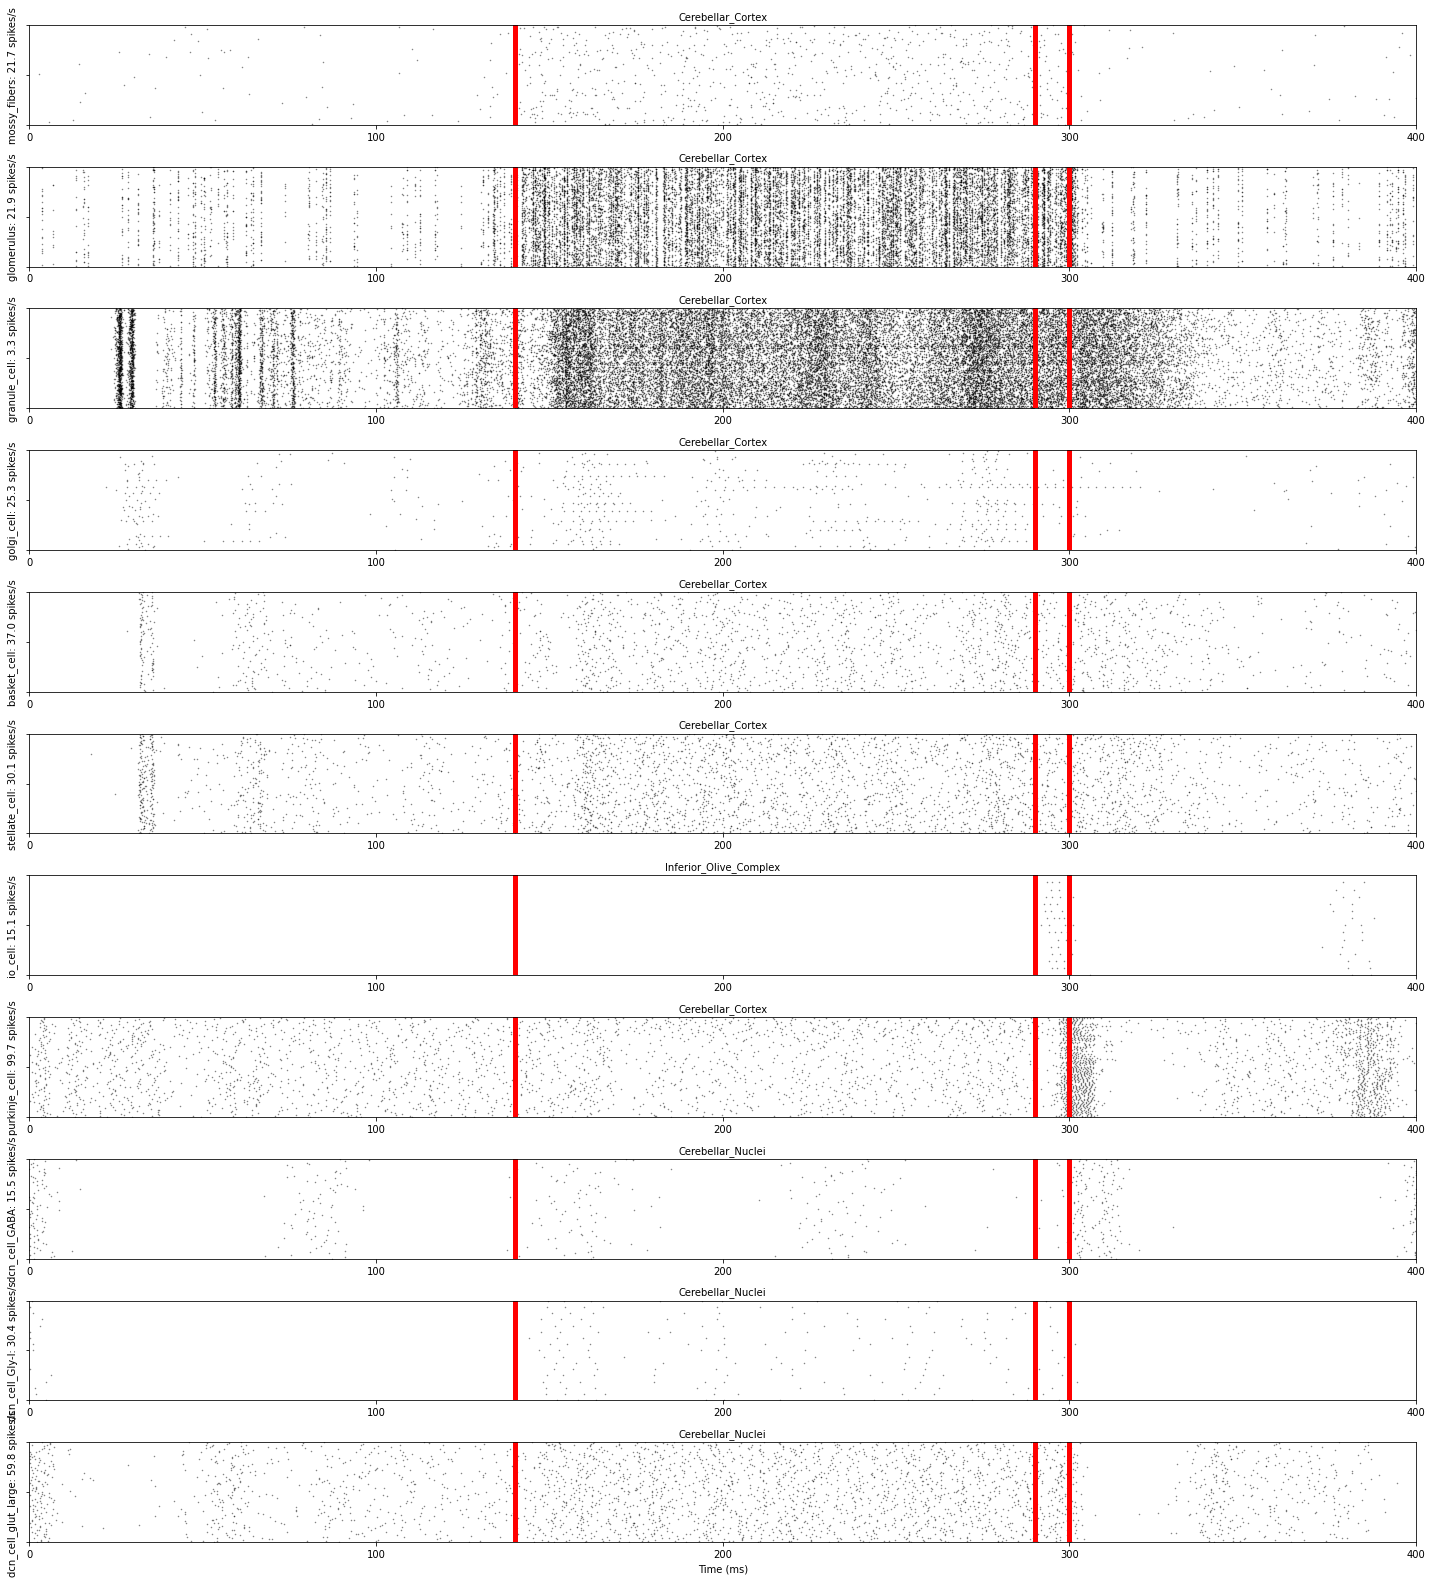

<Figure size 432x288 with 0 Axes>

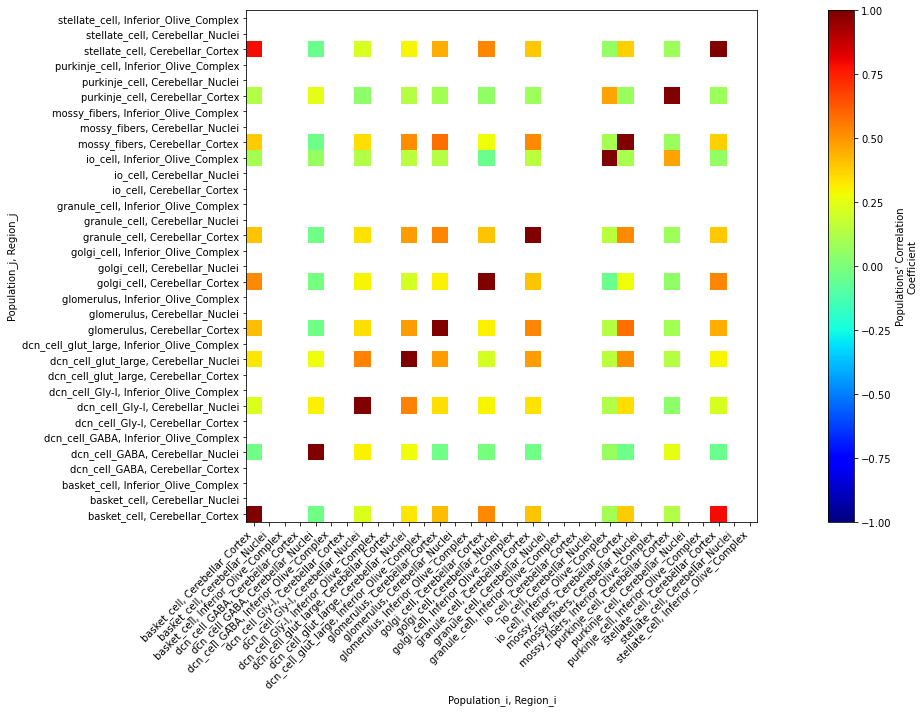

In [20]:
if spikes_res:
    print(spikes_res["mean_rate"])
    print(spikes_res["spikes_correlation_coefficient"])
    # Plot spikes' rasters together with mean population's spikes' rates' time series
    if plotter:
        plotter.plot_spike_events(spikes_res["spikes"], mean_results=spikes_res["mean_rate"], # time_series=spikes_res["mean_rate_time_series"], 
                                  figsize=(20, 22),  
                                  stimulus=[STIM_MF_START, STIM_IO_START, STIM_MF_END, STIM_IO_END],
                                  stimulus_linewidth=5.0,
                                  spikes_markersize=0.5, spikes_alpha=0.5,
                                  n_y_ticks=3, n_time_ticks=5, show_time_axis=True, 
                                  time_axis_min=0.0, time_axis_max=TOT_DURATION)
        from tvb_multiscale.core.plot.correlations_plot import plot_correlations
        plot_correlations(spikes_res["spikes_correlation_coefficient"], plotter)

In [21]:
if spikes_res:
    print("Mean spike rates:")
    for pop in spikes_res["mean_rate"].coords["Population"]:
        for reg in spikes_res["mean_rate"].coords["Region"]:
            if not np.isnan(spikes_res["mean_rate"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_res["mean_rate"].loc[pop, reg].values.item()))

    # savemat(os.path.join(config.out.FOLDER_RES, "spikes_mean_rates.mat"), spikes_res["mean_rate"].to_dict())


Mean spike rates:
mossy_fibers - Cerebellar_Cortex: 21.7474
glomerulus - Cerebellar_Cortex: 21.9348
granule_cell - Cerebellar_Cortex: 3.25011
golgi_cell - Cerebellar_Cortex: 25.3175
basket_cell - Cerebellar_Cortex: 37.0498
stellate_cell - Cerebellar_Cortex: 30.1218
io_cell - Inferior_Olive_Complex: 15.0794
purkinje_cell - Cerebellar_Cortex: 99.75
dcn_cell_GABA - Cerebellar_Nuclei: 15.4762
dcn_cell_Gly-I - Cerebellar_Nuclei: 30.3922
dcn_cell_glut_large - Cerebellar_Nuclei: 59.8191


In [22]:
if spikes_res and writer:
    writer.write_object(spikes_res["spikes"].to_dict(), 
                        path=os.path.join(config.out.FOLDER_RES,  "Spikes") + ".h5");
    writer.write_object(spikes_res["mean_rate"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["mean_rate"].name) + ".h5");
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                              spikes_res["mean_rate_time_series"]._data,
                               connectivity=spikes_res["mean_rate_time_series"].connectivity),
                           os.path.join(config.out.FOLDER_RES,
                                        spikes_res["mean_rate_time_series"].title) + ".h5",
                           recursive=False);
    writer.write_object(spikes_res["spikes_correlation_coefficient"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["spikes_correlation_coefficient"].name) + ".h5");

###### 